In [52]:
import torch 
from sklearn.model_selection import train_test_split
import rdkit

import random
import re
from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import unicodedata
import datetime
import time
import copy

import os
print(os.getcwd())

/home/Zhouyu/MODEL/translate


In [53]:
ngpu = 4

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if (use_cuda and ngpu > 0) else "cpu")
print(device)

cuda:0


In [54]:
cwd = os.getcwd()
data_dir = cwd + '/data/'

In [55]:
data_df = pd.read_csv(data_dir + 'uspto_data.txt', names=['reactant->reagent->product'],
                      nrows=250000)

In [56]:

data_df[['reactant', 'reagent', 'product']]= data_df['reactant->reagent->product'].str.split('>', expand=True)

In [57]:
data_df.drop('reactant->reagent->product', axis=1, inplace=True)


In [58]:
data_df.to_csv('ustpo250k.csv', index=False)

In [64]:
data_df.values[8]

array(['C(C(CCCC)C[OH:5])C.C(N(CC)CC)C.[C:17]1([CH2:23][C:24](Cl)=[O:25])[CH:22]=[CH:21][CH:20]=[CH:19][CH:18]=1',
       'C(Cl)Cl',
       '[C:17]1([CH2:23][C:24]([OH:25])=[O:5])[CH:22]=[CH:21][CH:20]=[CH:19][CH:18]=1'],
      dtype=object)

In [65]:
mol = rdkit.Chem.MolFromSmiles('[C:17]1([CH2:23][C:24]([OH:25])=[O:5])[CH:22]=[CH:21][CH:20]=[CH:19][CH:18]=1')

In [66]:
smiles = rdkit.Chem.MolToSmiles(mol)

In [67]:
smiles

'[O:5]=[C:24]([CH2:23][c:17]1[cH:18][cH:19][cH:20][cH:21][cH:22]1)[OH:25]'

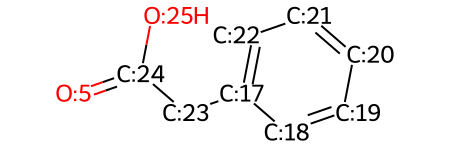

In [68]:
mol

In [69]:
new_mol = rdkit.Chem.MolFromSmiles('[O:5]=[C:24]([CH2:23][c:17]1[cH:18][cH:19][cH:20][cH:21][cH:22]1)[OH:25]')

In [71]:
new_smiles = rdkit.Chem.MolToSmiles(new_mol)

In [72]:
new_smiles

'[O:5]=[C:24]([CH2:23][c:17]1[cH:18][cH:19][cH:20][cH:21][cH:22]1)[OH:25]'

In [73]:
for atom in mol.GetAtoms():
    atom.SetAtomMapNum(0)

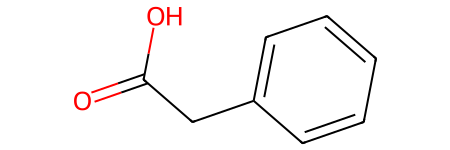

In [74]:
mol

In [84]:
for col in data_df.columns:
    mol_series = data_df[col]
    print(mol_series)
    for mol in mol_series.values:
        print(mol)
        mol = rdkit.Chem.MolFromSmiles(mol)
        for atom in mol.GetAtoms():
            atom.SetAtomMapNum(0)
        mol = rdkit.Chem.MolToSmiles(mol)
        print(mol)
        break
    break

0         [C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7...
1         [Cl-].[Al+3].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...
2         [Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...
3         [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...
4         [Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...
                                ...                        
249995    [O:1]1[C:5]2[CH:6]=[CH:7][C:8]([C:10]([C:12]3[...
249996    [CH2:1]([O:3][C:4]1[CH:5]=[C:6]([CH:9]=[CH:10]...
249997    [O:1]1[C:6]2[CH:7]=[CH:8][C:9]([C:11]([C:13]3[...
249998    [CH3:1][O:2][C:3]1[CH:4]=[C:5]([CH:9]=[C:10]([...
249999    [CH3:1][O:2][C:3]1[CH:4]=[C:5]([C:11]([C:13]2[...
Name: reactant, Length: 250000, dtype: object
[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7][CH:6]=1)([CH3:4])([CH3:3])[CH3:2]
CC(C)(C)c1ccc(O)cc1


In [110]:
def smiles(smiles):
    
    mol = rdkit.Chem.MolFromSmiles(smiles)
    if mol is None:
        return 
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(0)
    return rdkit.Chem.MolToSmiles(mol)

In [114]:
for col in data_df.columns:
    data_df[col] = data_df[col].apply(smiles)

In [115]:
data_df.head()

,reactant,reagent,product
0,CC(C)(C)c1ccc(O)cc1,[Ni],CC(C)(C)C1CCC(O)CC1
1,CC(C)c1ccccc1.O=C(Cl)CCCCl.[Al+3].[Cl-].[Cl-]....,ClCCl,CC(C)c1ccc(C(=O)CCCCl)cc1
2,Cc1ccccc1.O=C(Cl)CCCCl.[Al+3].[Cl-].[Cl-].[Cl-],,Cc1ccc(C(=O)CCCCl)cc1
3,CC(C)c1ccc(C(=O)CCCCl)cc1.O=C(OOC(=O)c1ccccc1)...,ClC(Cl)(Cl)Cl,CC(C)(Br)c1ccc(C(=O)CCCCl)cc1
4,CC(C)c1ccc(C(=O)CCCCl)cc1.O=C1CCC(=O)N1Br,CC(C)(C#N)N=NC(C)(C)C#N.ClC(Cl)(Cl)Cl,CC(C)(Br)c1ccc(C(=O)CCCCl)cc1


In [119]:
empty_rows = data_df[data_df.isnull().any(axis=1)]


pandas.core.frame.DataFrame

In [123]:
data_df[data_df.isnull().any(axis=1)]

,reactant,reagent,product
1025,CNc1ccc(C(=O)OC)cc1.COCO[C@H]1CCN(C[C@@H](O)c2...,,None
3372,None,ClCCl,COc1ccc2c(c1)CCC(Br)=C2c1ccc(OCCN2CCCC2)nc1
9732,None,,CC(=O)c1cccc(NC(=O)Oc2ccc([N+](=O)[O-])cc2)c1
10965,None,C1CCOC1,O=C(NC1(CO)CC1)OCc1ccccc1
18325,None,C1CCOC1.ClC(Cl)Cl.[Pd].c1ccc(P(c2ccccc2)c2cccc...,O=C1c2ccccc2C(=O)N1CCc1c(-c2ccccc2)[nH]c2ccc([...
...,...,...,...
222348,ClP(Cl)(Cl)(Cl)Cl.O=C(O)c1ccccc1-c1c2ccc(=O)cc...,Clc1ccccc1,None
227322,None,Clc1ccccc1,CC(C)n1c(Br)c(-c2ccc(F)cc2)c2ccccc21
229458,None,CC(=O)O.O,N#Cc1c(O)c2c(-c3ccc(Cl)cc3)c(Br)sc2[nH]c1=O
244230,O=S(=O)(O)O.OO.[Na+].[O-][Cl+2]([O-])[O-],,None


In [124]:
data_df.values[244230]

array(['O=S(=O)(O)O.OO.[Na+].[O-][Cl+2]([O-])[O-]', '', None],
      dtype=object)

In [125]:
data = pd.read_csv('ustpo250k.csv')

In [126]:
data.head()

,reactant,reagent,product
0,[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7...,[Ni],[C:1]([CH:5]1[CH2:6][CH2:7][CH:8]([OH:11])[CH2...
1,[Cl-].[Al+3].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...,C(Cl)Cl,[Cl:5][CH2:6][CH2:7][CH2:8][C:9]([C:15]1[CH:16...
2,[Al+3].[Cl-].[Cl-].[Cl-].[Cl:5][CH2:6][CH2:7][...,NaN,[Cl:5][CH2:6][CH2:7][CH2:8][C:9]([C:15]1[CH:16...
3,[Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...,C(Cl)(Cl)(Cl)Cl,[Br:16][C:13]([C:10]1[CH:9]=[CH:8][C:7]([C:5](...
4,[Cl:1][CH2:2][CH2:3][CH2:4][C:5]([C:7]1[CH:12]...,C(Cl)(Cl)(Cl)Cl.CC(N=NC(C#N)(C)C)(C#N)C,[Br:16][C:13]([C:10]1[CH:9]=[CH:8][C:7]([C:5](...


In [158]:
data.values[0]

array(['[C:1]([C:5]1[CH:10]=[CH:9][C:8]([OH:11])=[CH:7][CH:6]=1)([CH3:4])([CH3:3])[CH3:2]',
       '[Ni]',
       '[C:1]([CH:5]1[CH2:6][CH2:7][CH:8]([OH:11])[CH2:9][CH2:10]1)([CH3:4])([CH3:2])[CH3:3]'],
      dtype=object)

In [173]:
df = data_df.dropna()

In [177]:
df.to_csv('ustpo250k_standard.csv', index=False)